# Practicumopdracht 3

Eerst wordt er geïmporteerd: libraries, csv bestand en functies die later gebruikt gaan worden.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
sns.set_style('whitegrid')
import statsmodels
import scipy
from scipy.stats import norm
import math
import numpy as np
import statsmodels.tsa.seasonal
import statsmodels.graphics.tsaplots
import matplotlib
from scipy.special import inv_boxcox
import lifelines
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('helpdesk.csv')

In [4]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = statsmodels.tsa.stattools.adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(dftest[0:4], index=["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used",],)
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = statsmodels.tsa.stattools.kpss(timeseries, regression="c",
    nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"])
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [5]:
# functie voor plotten van time series
def plot_series(df, series_name, lags=40, diff=0, seasonal_diff=0, seasonal_period=12):
    """
    Plot a time series alongside its ACF and PACF with Bartlett bounds.
    Includes options for regular and seasonal differencing.
    
    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing multiple time series as columns.
    series_name : str
        Column name of the series to plot.
    lags : int
        Number of lags for ACF/PACF.
    diff : int, default=0
        Number of regular differences to apply.
    seasonal_diff : int, default=0
        Number of seasonal differences to apply.
    seasonal_period : int, default=12
        Seasonal period (e.g., 12 for monthly data with yearly seasonality).
    """
    series = df[series_name]

    # Apply differencing
    for _ in range(diff):
        series = series.diff()
    for _ in range(seasonal_diff):
        series = series.diff(seasonal_period)
    series = series.dropna()
    
    print(adf_test(series))
    print(kpss_test(series))

    # Compute ACF/PACF (drop lag 0)
    acf_vals = acf(series, nlags=lags, fft=False)[1:]
    pacf_vals = pacf(series, nlags=lags, method="ywm")[1:]
    lags_range = np.arange(1, len(acf_vals)+1)

    # Bartlett bounds
    n = len(series)
    conf = 1.96 / np.sqrt(n)

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Time series
    axes[0].plot(series.index, series.values, color="steelblue")
    axes[0].set_title(f"Series: {series_name} (diff={diff}, seas_diff={seasonal_diff})")

    # ACF
    axes[1].stem(lags_range, acf_vals, basefmt=" ")
    axes[1].hlines([conf, -conf], xmin=0, xmax=lags, colors="red", linestyles="dashed")
    axes[1].axhline(0, color="black", linewidth=0.8)
    axes[1].set_title("ACF-plot")

    # PACF
    axes[2].stem(lags_range, pacf_vals, basefmt=" ")
    axes[2].hlines([conf, -conf], xmin=0, xmax=lags, colors="red", linestyles="dashed")
    axes[2].axhline(0, color="black", linewidth=0.8)
    axes[2].set_title("PACF-plot")

    plt.tight_layout()
    plt.show()

In [6]:
# gebruikelijke evaluation metrics voor time series forecasting
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

def mape(y_true, y_pred):
    return 100 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_true)))

# functies voor time series cross-validation
def cv_single_arima(series, order, seasonal_order, splits, metric=rmse):
    """
    Evaluate one ARIMA specification across CV splits.
    
    Returns the average error across folds.
    """
    errors = []

    for train_idx, test_idx in splits:
        train = series.iloc[train_idx]
        test = series.iloc[test_idx]

        model = ARIMA(train, order=order, seasonal_order=seasonal_order)
        fitted = model.fit()

        fc = fitted.forecast(steps=len(test))
        error = metric(test.values, fc.values)
        errors.append(error)

    return np.mean(errors)

def cv_arima_candidates(series, candidates, splits, metric=rmse):
    """
    Evaluate multiple ARIMA candidates.
    
    Parameters
    ----------
    candidates : list of dicts
        Example:
        [
            {"order": (1,1,1), "seasonal_order": (0,1,1,12)},
            {"order": (2,1,0), "seasonal_order": (1,1,0,12)}
        ]
    """
    results = []

    for spec in candidates:
        avg_error = cv_single_arima(
            series,
            order=spec["order"],
            seasonal_order=spec["seasonal_order"],
            splits=splits,
            metric=metric
        )
        results.append({
            "order": spec["order"],
            "seasonal_order": spec["seasonal_order"],
            "cv_error": avg_error
        })

    return pd.DataFrame(results)

# functies voor visualiseren fouten
def horizon_errors(series, order, seasonal_order, H, splits, metric):
    """
    Compute horizon-wise forecast errors for ARIMA using any CV splits.
    
    Parameters
    ----------
    series : pd.Series
    order : tuple
    seasonal_order : tuple
    H : int
        Maximum forecast horizon.
    splits : list of (train_idx, test_idx)
        Output of make_time_series_splits (expanding or sliding).
    """
    errors = {h: [] for h in range(1, H+1)}

    for train_idx, test_idx in splits:
        train = series.iloc[train_idx]
        test = series.iloc[test_idx]

        model = ARIMA(train, order=order, seasonal_order=seasonal_order)
        fitted = model.fit()

        fc = fitted.forecast(steps=H)

        for h in range(1, H+1): 
            e = metric(test.iloc[h-1], fc.iloc[h-1]) 
            errors[h].append(e)

    avg_errors = {h: np.mean(errors[h]) for h in errors}
    return avg_errors, errors

def plot_horizon_boxplot(all_errors):
    """
    Boxplot of horizon-wise forecast errors.
    """
    horizons = list(all_errors.keys())
    data = [all_errors[h] for h in horizons]

    plt.figure(figsize=(10, 5))
    plt.boxplot(data, labels=horizons, showfliers=True)
    plt.xlabel("Forecast horizon (steps ahead)")
    plt.ylabel("")
    plt.title("Forecast error distribution")
    plt.grid(axis='y', alpha=0.3)
    plt.show()
    
# functie voor maken van time series cross-validation splits
def make_time_series_splits(series, initial_window, horizon=1, step=1, window_type="expanding"):
    """
    Generate time-series cross-validation splits.

    Parameters
    ----------
    series : pd.Series
        Time series (DateTimeIndex or RangeIndex).
    initial_window : int
        Number of observations in the first training window.
    horizon : int
        Forecast horizon (steps ahead).
    step : int
        How many steps to move the origin each iteration.
    window_type : str
        "expanding"  -> training window grows over time
        "sliding"    -> training window has fixed size

    Returns
    -------
    splits : list of tuples
        Each tuple is (train_idx, test_idx), where each is an array of positions.
    """
    n = len(series)
    splits = []

    start = initial_window

    while start + horizon <= n:
        if window_type == "expanding":
            # Training window always starts at 0
            train_idx = np.arange(0, start)

        elif window_type == "sliding":
            # Fixed-size training window
            train_idx = np.arange(start - initial_window, start)

        else:
            raise ValueError("window_type must be 'expanding' or 'sliding'")

        test_idx = np.arange(start, start + horizon)
        splits.append((train_idx, test_idx))

        start += step

    return splits

#### Vraag a: Hoeveel tickets kan de helpdesk in totaal verwachten in november 2025 en hoe is dat aantal hoeveelheid verdeeld over de maand?

In [7]:
df['start_date'] = pd.to_datetime(df['start_date'])
df['end_date'] = pd.to_datetime(df['end_date'])

In [5]:
start_date_data = df.groupby(['start_date']).size().reset_index(name='aantal')

Eerst is de data bekeken om te zien wat de verdeling is van het aantal dagen dat nodig is om een ticket op te lossen. Er is een histogram gemaakt en het gemiddelde is bepaald.

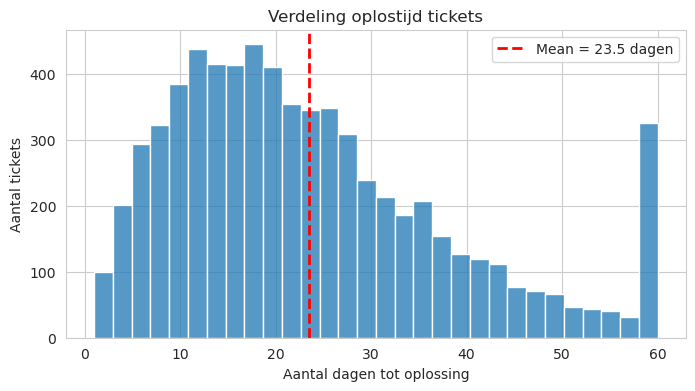

In [7]:
df["dagen_nodig"] = (df["end_date"] - df["start_date"]).dt.days
resolved = df[df["end_date"].notna()]
mean_days = resolved["dagen_nodig"].mean()

plt.figure(figsize=(8,4))
sns.histplot(data=resolved, x="dagen_nodig", bins=30)

plt.axvline(mean_days, color="red", linestyle="--", linewidth=2, label=f"Mean = {mean_days:.1f} dagen")

plt.xlabel("Aantal dagen tot oplossing")
plt.ylabel("Aantal tickets")
plt.title("Verdeling oplostijd tickets")
plt.legend(loc="upper right")
plt.show()

Er wordt een lijnplot gemaakt over hoeveel tickets er elke dag worden aangevraagd. De stationariteit wordt getest met de ADF- en KPSS-testen.

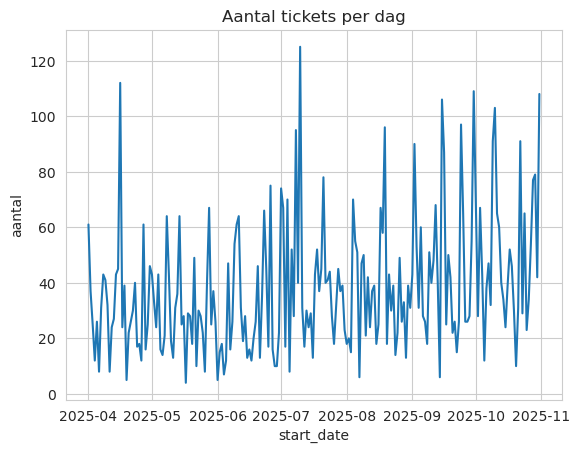

Results of Dickey-Fuller Test:
Test Statistic                  -1.405110
p-value                          0.579824
#Lags Used                      14.000000
Number of Observations Used    198.000000
Critical Value (1%)             -3.463815
Critical Value (5%)             -2.876251
Critical Value (10%)            -2.574611
dtype: float64
Results of KPSS Test:
Test Statistic           1.377948
p-value                  0.010000
Lags Used                3.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


In [16]:
sns.lineplot(start_date_data, x='start_date', y='aantal')
plt.title("Aantal tickets per dag")
plt.show()

adf_test(start_date_data['aantal'])
kpss_test(start_date_data['aantal'])

In de lijnplot lijkt er een terugkomend patroon zijn: dit duidt op seasonality. Er zou ook een lichte opwaartse trend kunnen zijn richting het einde van de data. De lijnplot lijkt ook heteroscedastisch, alsof de amplitude groter wordt naarmate de tijd vordert. De variantie lijkt toe te nemen in de tijd terwijl get gemiddelde ook langzaam stijgt.

Volgens de twee testen is de data niet stationair. Hieronder wordt de time series stationair gemaakt, zodat de kansverdeling niet varieert met de tijd.

Omdat er een licht stijgende trend te zien, is er al eerst geprobeerd om met een power transformatie de trend lineair te maken. Dit is gedaan door de wortel te nemen van de data:

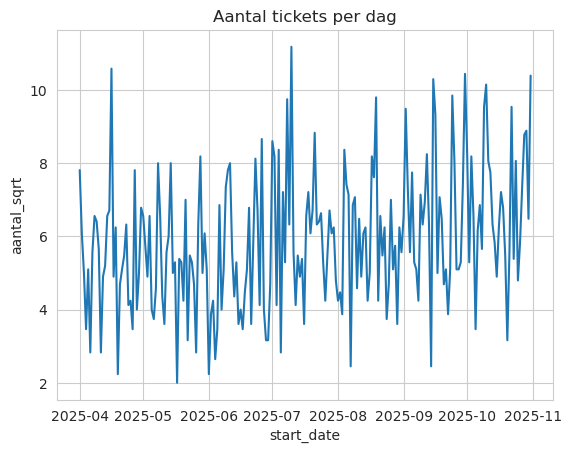

Results of Dickey-Fuller Test:
Test Statistic                  -1.328444
p-value                          0.616061
#Lags Used                      14.000000
Number of Observations Used    198.000000
Critical Value (1%)             -3.463815
Critical Value (5%)             -2.876251
Critical Value (10%)            -2.574611
dtype: float64
Results of KPSS Test:
Test Statistic           1.475956
p-value                  0.010000
Lags Used                3.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


In [20]:
start_date_data['aantal_sqrt'] = np.sqrt(start_date_data['aantal'])
sns.lineplot(start_date_data, x='start_date', y='aantal_sqrt')
plt.title("Aantal tickets per dag")
plt.show()

adf_test(start_date_data['aantal_sqrt'])
kpss_test(start_date_data['aantal_sqrt'])

De trend lijkt wel meer lineair te zijn in plaats van exponentieël. Helaas is het nog niet stationair.

Hierna gaan we de time series homoscedastisch maken, door een Box-Cox transformatie uit te voeren:

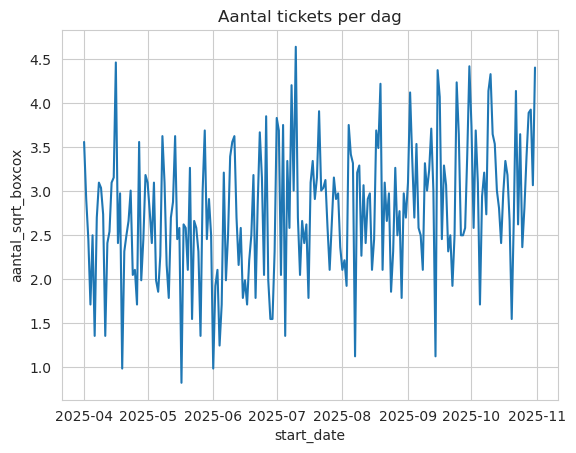

Results of Dickey-Fuller Test:
Test Statistic                  -1.325373
p-value                          0.617486
#Lags Used                      14.000000
Number of Observations Used    198.000000
Critical Value (1%)             -3.463815
Critical Value (5%)             -2.876251
Critical Value (10%)            -2.574611
dtype: float64
Results of KPSS Test:
Test Statistic           1.503822
p-value                  0.010000
Lags Used                3.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


In [23]:
start_date_data['aantal_sqrt_boxcox'], fitted_lambda = scipy.stats.boxcox(start_date_data['aantal_sqrt'])

sns.lineplot(start_date_data, x='start_date', y='aantal_sqrt_boxcox')
plt.title("Aantal tickets per dag")
plt.show()

adf_test(start_date_data['aantal_sqrt_boxcox'])
kpss_test(start_date_data['aantal_sqrt_boxcox'])

De lijnplot ziet er niet meer heteroscedastisch uit, maar het is nog steeds niet stationair.

Er zitten nog hoge pieken in die seasonality aan zouden kunnen duiden, dus er wordt met behulp van de ACF- en PACF-plot gekeken of hier inderdaad sprake van is.

Results of Dickey-Fuller Test:
Test Statistic                  -1.325373
p-value                          0.617486
#Lags Used                      14.000000
Number of Observations Used    198.000000
Critical Value (1%)             -3.463815
Critical Value (5%)             -2.876251
Critical Value (10%)            -2.574611
dtype: float64
None
Results of KPSS Test:
Test Statistic           1.503822
p-value                  0.010000
Lags Used                3.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
None


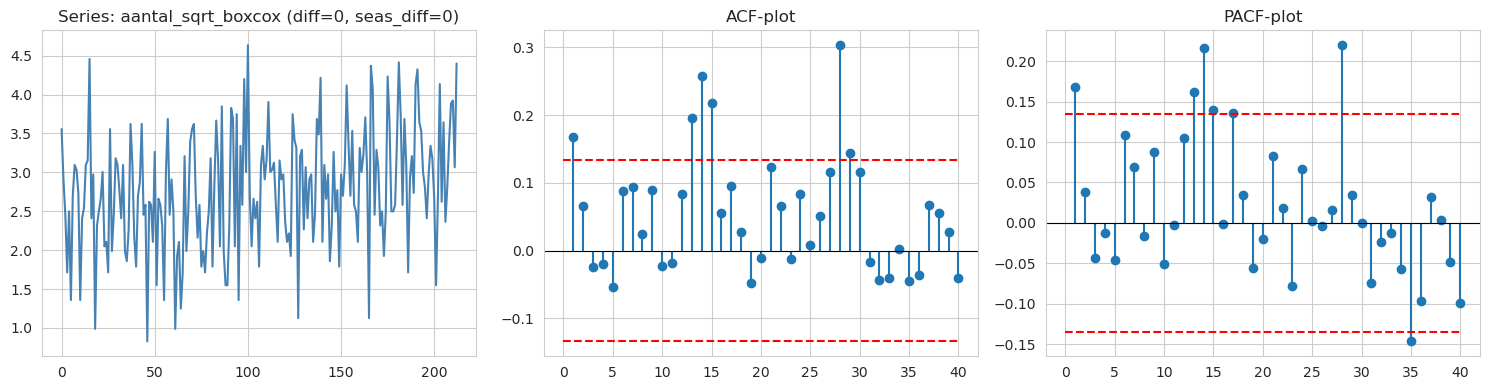

In [27]:
plot_series(start_date_data, 'aantal_sqrt_boxcox', lags=40)

In de ACF-plot is er om de 14 dagen een uitschieter te zien, dit duidt op seasonality met een periode van 14 dagen. Dus er wordt seasonal differencing toegepast met $m = 14$.

Results of Dickey-Fuller Test:
Test Statistic                  -5.562181
p-value                          0.000002
#Lags Used                      13.000000
Number of Observations Used    185.000000
Critical Value (1%)             -3.466201
Critical Value (5%)             -2.877293
Critical Value (10%)            -2.575168
dtype: float64
None
Results of KPSS Test:
Test Statistic           0.058716
p-value                  0.100000
Lags Used                8.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
None


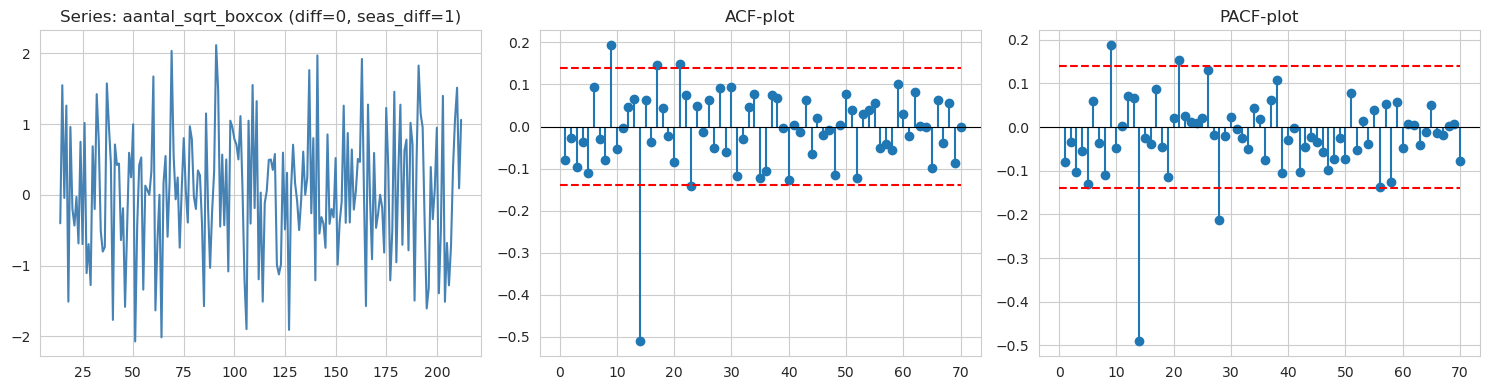

In [31]:
plot_series(start_date_data, 'aantal_sqrt_boxcox', lags=70, diff=0, seasonal_diff=1, seasonal_period=14)

Nu is die stationair! Er is ook geen sprake meer van een trend, dus normale differencing om de trend te verwijderen is niet meer nodig.

Nu wordt er een model gemaakt. Er wordt gekozen voor $(p,d,q) = (0,0,0)$ en $(P,D,Q)=(1,1,2)$.

ACF-plot is heel lichtelijk dempend oscillerend, de PACF ook. $p = 0$ want er is geen significante eerste lag in de PACF-plot. $d=0$, want er wordt geen differencing gedaan. $q=0$ want er is ook geen significante eerste lag in de ACF-plot.

De veelvouden van 14 zijn assymptotisch in de ACF- en in de PACF-plot. $P=1$ en $Q=2$, omdat dat de uitschieters aan de onderkant zijn. $D=1$ want er is één keer seasonal differencing toegepast.

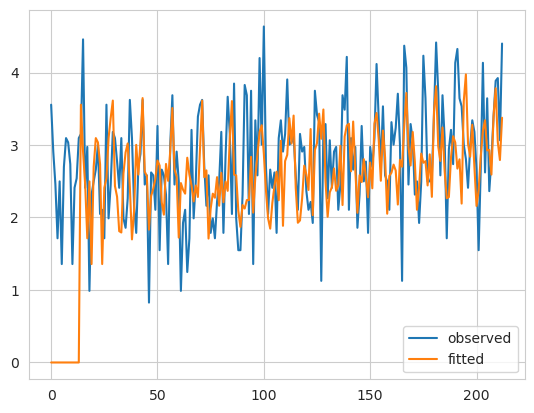

In [33]:
model = ARIMA(start_date_data["aantal_sqrt_boxcox"], order=(0,0,0), seasonal_order=(1,1,2,14))
fitted = model.fit()

y = start_date_data["aantal_sqrt_boxcox"]
fv = fitted.fittedvalues

y_aligned, fv_aligned = y.align(fv, join="inner")

plt.plot(y_aligned.index, y_aligned, label="observed")
plt.plot(fv_aligned.index, fv_aligned, label="fitted")
plt.legend()
plt.show()

Voordat er voorspeld wordt, wordt er nog met behulp cross-validation het beste model gezocht. We hebben gekozen voor $0 \le p+q \le 3$ en $1 \le P+Q \le 4$.

In [47]:
kandidaatmodellen = [
    {"order": (0,0,0), "seasonal_order": (1,1,2,14)},  # Huidig model
    {"order": (1,0,1), "seasonal_order": (0,1,1,14)},
    {"order": (0,0,0), "seasonal_order": (1,1,0,14)},
    {"order": (1,0,0), "seasonal_order": (1,1,0,14)},
    {"order": (0,0,1), "seasonal_order": (1,1,0,14)},
    {"order": (2,0,1), "seasonal_order": (1,1,0,14)},
    {"order": (0,0,2), "seasonal_order": (0,1,1,14)},
    {"order": (0,0,1), "seasonal_order": (0,1,1,14)},
    {"order": (0,0,0), "seasonal_order": (1,1,1,14)},
    {"order": (0,0,0), "seasonal_order": (0,1,2,14)},
    {"order": (0,0,0), "seasonal_order": (2,1,1,14)},
    {"order": (1,0,0), "seasonal_order": (2,1,2,14)},
    {"order": (0,0,1), "seasonal_order": (0,1,3,14)},
    {"order": (1,0,1), "seasonal_order": (1,1,2,14)},
    {"order": (1,0,0), "seasonal_order": (1,1,1,14)},
    {"order": (0,0,1), "seasonal_order": (1,1,1,14)},
    {"order": (1,0,1), "seasonal_order": (1,1,1,14)},
    {"order": (2,0,0), "seasonal_order": (1,1,0,14)},
    {"order": (1,0,0), "seasonal_order": (0,1,2,14)},
    {"order": (1,0,1), "seasonal_order": (0,1,2,14)}]

In deze functie is gekozen voor horizon van 30 want het doel is om 30 dagen vooruit te voorspellen.

De grootste P+Q is 4, dus (4x14) 56 maanden is genoeg om te kunnen fitten. Omdat de trainingsset minstens twee keer zo groot moet zijn is er een initial window van (2x56) 112 gekozen.

In [49]:
series = start_date_data['aantal_sqrt_boxcox']
splits = make_time_series_splits(series, initial_window=112, horizon=30, window_type="expanding")
cv_arima_candidates(series, kandidaatmodellen, splits)

,order,seasonal_order,cv_error
0,"(0, 0, 0)","(1, 1, 2, 14)",0.698187
1,"(1, 0, 1)","(0, 1, 1, 14)",0.693092
2,"(0, 0, 0)","(1, 1, 0, 14)",0.730188
3,"(1, 0, 0)","(1, 1, 0, 14)",0.730186
4,"(0, 0, 1)","(1, 1, 0, 14)",0.730193
5,"(2, 0, 1)","(1, 1, 0, 14)",0.730888
6,"(0, 0, 2)","(0, 1, 1, 14)",0.693200
7,"(0, 0, 1)","(0, 1, 1, 14)",0.692826
8,"(0, 0, 0)","(1, 1, 1, 14)",0.692792
9,"(0, 0, 0)","(0, 1, 2, 14)",0.692838


Het beste model is die met de laagste RMSE, in dit geval is dat model 15 (0,0,1) (1,1,1,14):

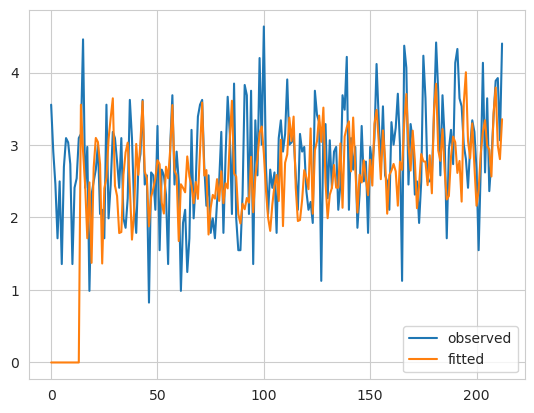

In [50]:
model = ARIMA(start_date_data["aantal_sqrt_boxcox"], order=(0,0,1), seasonal_order=(1,1,1,14))
fitted = model.fit()

y = start_date_data["aantal_sqrt_boxcox"]
fv = fitted.fittedvalues

y_aligned, fv_aligned = y.align(fv, join="inner")

plt.plot(y_aligned.index, y_aligned, label="observed")
plt.plot(fv_aligned.index, fv_aligned, label="fitted")
plt.legend()
plt.show()

Voordat de voorspelling gedaan wordt moeten de transformaties geïnverteerd worden.

In [55]:
forecast_res = fitted.get_forecast(steps=30)

forecast_mean = forecast_res.predicted_mean
forecast_ci = forecast_res.conf_int()

In [58]:
z_hat = inv_boxcox(forecast_mean, fitted_lambda)
y_hat = z_hat ** 2
total_forecast = y_hat.sum()
print(f'Aantal nieuwe tickets in november: {total_forecast}')

Aantal nieuwe tickets in november: 1262.465257673312


In [66]:
org_y = start_date_data['aantal']
z_conf = inv_boxcox(forecast_ci, fitted_lambda)
y_conf = z_conf ** 2

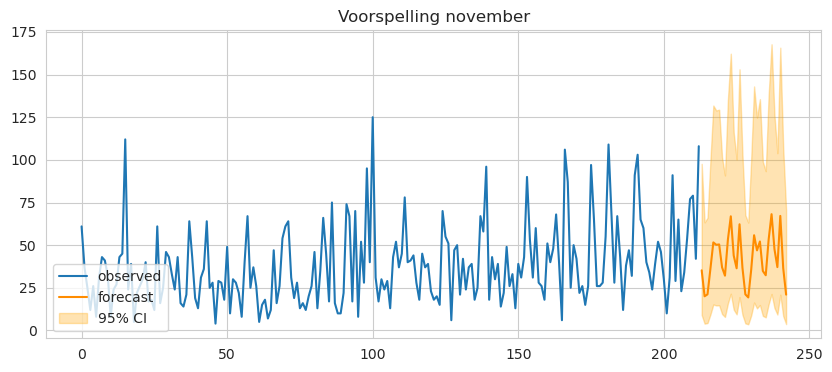

In [67]:
plt.figure(figsize=(10,4))

plt.plot(org_y.index, org_y, label="observed")
plt.plot(y_hat.index, y_hat, label="forecast", color="darkorange")

plt.fill_between(y_conf.index, y_conf.iloc[:, 0], y_conf.iloc[:, 1],color="orange", alpha=0.3,label="95% CI")

plt.legend(loc='lower left')
plt.title("Voorspelling november")
plt.show()


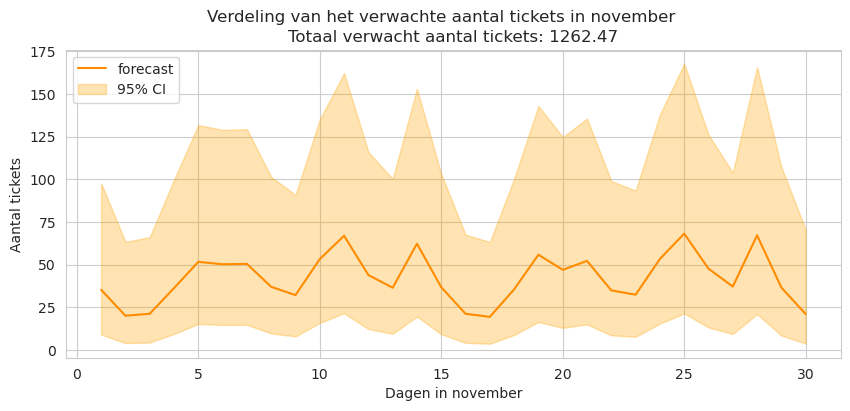

In [81]:
plt.figure(figsize=(10,4))

plt.plot(y_hat.reset_index().index+1, y_hat, label="forecast", color="darkorange")

plt.fill_between(y_conf.reset_index().index+1, y_conf.iloc[:, 0], y_conf.iloc[:, 1],color="orange", alpha=0.3,label="95% CI")

plt.legend(loc='upper left')
plt.suptitle("Verdeling van het verwachte aantal tickets in november")
plt.title(f'Totaal verwacht aantal tickets: {total_forecast:.2f}')
plt.xlabel('Dagen in november')
plt.ylabel('Aantal tickets')
plt.show()

Het verwachte aantal tickets in november zijn er 1262,47. Hierboven in de grafiek is per dag te zien hoeveel tickets er worden aangevraagd.

#### Vraag b: Hoeveel tickets zal de helpdesk naar verwachting in november 2025 afgehandeld hebben? Welke factoren of aspecten spelen daar een belangrijke rol in

#### Om te beantwoorden welke factoren belangreijk zijn bij het afhandelen van tickets zal gebruik gemaakt worden van survival analyse. 

Eerst word een individual based summary gemaakt.
Hierbij wordt het oplossen van een ticket gedefinieerd als event. De survival time is het aantal dagen dat een ticket open is geweest. Censoring is gedefineerd als een ticket de status `cancelled` heeft.


In [11]:
df_ibs = pd.DataFrame()

df_ibs = pd.get_dummies(df, columns=['priority', 'experience_cat', 'type'], drop_first=False)
df_ibs["Event"] = df["status"].map({'completed': 1, 'ongoing': 0, 'cancelled': 0})
df_ibs['Censoring'] = df['status'] == 'cancelled'
df_ibs['team_size'] = df['team_size']
df_ibs['budget'] = df['budget']

df_ibs["stop_date"] = df_ibs["end_date"]
cutoff = df_ibs["start_date"].max()  # of een vaste datum, of df_ibs["start_date"].max()

df_ibs.loc[df_ibs["stop_date"].isna(), "stop_date"] = cutoff
df_ibs["Survival_time"] = (df_ibs["stop_date"] - df_ibs["start_date"]).dt.days


df_ibs.head()

,start_date,team_size,budget,status,end_date,priority_high,priority_low,priority_medium,experience_cat_high,experience_cat_low,experience_cat_medium,type_bug,type_chore,type_doc,type_feature,Event,Censoring,stop_date,Survival_time
0,2025-04-01,7,43200,completed,2025-05-30,False,False,True,False,False,True,True,False,False,False,1,False,2025-05-30,59
1,2025-04-01,4,36800,completed,2025-04-23,False,False,True,False,False,True,False,False,False,True,1,False,2025-04-23,22
2,2025-04-01,3,47700,completed,2025-04-29,False,False,True,False,True,False,True,False,False,False,1,False,2025-04-29,28
3,2025-04-01,9,37000,completed,2025-05-31,False,False,True,False,True,False,False,True,False,False,1,False,2025-05-31,60
4,2025-04-01,4,58500,completed,2025-04-15,False,False,True,False,False,True,False,True,False,False,1,False,2025-04-15,14


Er wordt eerst een CoxPH model gefit op alle variabelen.

<lifelines.CoxPHFitter: fitted with 8115 total observations, 1315 right-censored observations>
             duration col = 'Survival_time'
                event col = 'Event'
      baseline estimation = breslow
   number of observations = 8115
number of events observed = 6800
   partial log-likelihood = -53959.80
         time fit was run = 2026-01-21 21:02:55 UTC

---
                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                              
team_size             -0.00      1.00      0.01           -0.01            0.01                0.99                1.01
budget                -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
priority_high          0.07      1.07      0.03            0.00            0.14                1.00                1.15
priority_medium        0.04      1.04      0.03           -0.02            0.10                0.98                1.10
experience_cat_medium  0.07      1.08      0.03            0.02            0.13                1.02                1.14
experience_cat_high    0.08      1.08      0.04            0.01            0.15                1.01                1.16
type_bug               0.07      1.07      0.06           -0.05            0.18                0.95                1.20
type_chore             0.11      1.12      0.06           -0.01            0.24                0.99                1.27
type_feature           0.03      1.03      0.06           -0.08            0.15                0.92                1.16

                       cmp to     z    p  -log2(p)
covariate                                         
team_size                0.00 -0.23 0.82      0.29
budget                   0.00 -0.30 0.76      0.39
priority_high            0.00  2.09 0.04      4.76
priority_medium          0.00  1.28 0.20      2.31
experience_cat_medium    0.00  2.63 0.01      6.89
experience_cat_high      0.00  2.25 0.02      5.36
type_bug                 0.00  1.12 0.26      1.92
type_chore               0.00  1.77 0.08      3.70
type_feature             0.00  0.58 0.56      0.82
---
Concordance = 0.50
Partial AIC = 107937.60
log-likelihood ratio test = 18.48 on 9 df
-log2(p) of ll-ratio test = 5.06

<Axes: xlabel='log(HR) (95% CI)'>

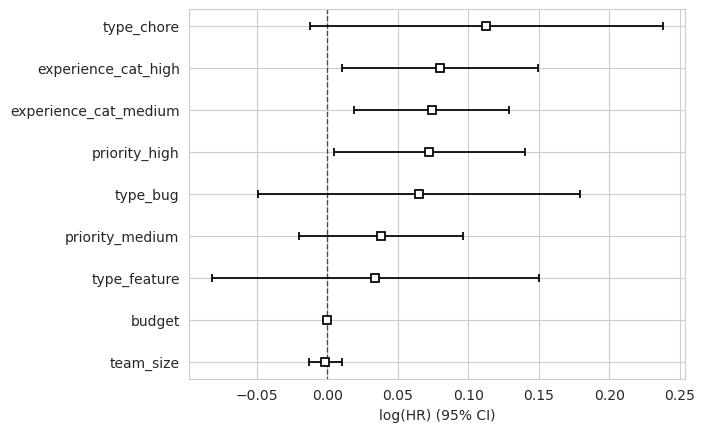

In [16]:
cph = lifelines.CoxPHFitter()
cph.fit(df_ibs, "Survival_time", "Event",
        formula="team_size + budget + priority_high + priority_medium + experience_cat_medium + experience_cat_high + type_bug + type_chore + type_feature")
cph.print_summary()
cph.plot()

In dit eerste model is te zien dat de volgende variabelen significant bijdragen aan het behalen van een event: `experience_cat_high`, `experience_cat_medium`, `type_chore`, `priority_high`. Deze factoren zullen opnieuw meegenomen worden in een volgend model.

<lifelines.CoxPHFitter: fitted with 8115 total observations, 1315 right-censored observations>
             duration col = 'Survival_time'
                event col = 'Event'
      baseline estimation = breslow
   number of observations = 8115
number of events observed = 6800
   partial log-likelihood = -53961.70
         time fit was run = 2026-01-21 20:53:12 UTC

---
                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                              
priority_high          0.05      1.05      0.03           -0.01            0.10                0.99                1.11
experience_cat_high    0.08      1.09      0.04            0.01            0.15                1.01                1.16
experience_cat_medium  0.08      1.08      0.03            0.02            0.13                1.02                1.14
type_chore             0.07      1.07      0.03           -0.00            0.13                1.00                1.14

                       cmp to    z    p  -log2(p)
covariate                                        
priority_high            0.00 1.65 0.10      3.34
experience_cat_high      0.00 2.31 0.02      5.60
experience_cat_medium    0.00 2.69 0.01      7.12
type_chore               0.00 1.91 0.06      4.14
---
Concordance = 0.49
Partial AIC = 107931.39
log-likelihood ratio test = 14.68 on 4 df
-log2(p) of ll-ratio test = 7.53

<Axes: xlabel='log(HR) (95% CI)'>

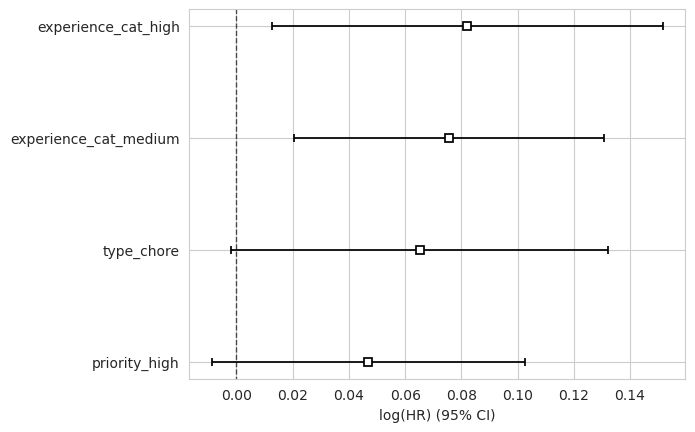

In [14]:
cph2 = lifelines.CoxPHFitter()
cph2.fit(df_ibs, duration_col='Survival_time', event_col='Event', formula = "priority_high + experience_cat_high + experience_cat_medium + type_chore")
cph2.print_summary()
cph2.plot()

In het tweede model is te zien dat `experience_cat_high` en `experience_cat_medium` alleen nog significant bijdragen.

<lifelines.CoxPHFitter: fitted with 8115 total observations, 1315 right-censored observations>
             duration col = 'Survival_time'
                event col = 'Event'
      baseline estimation = breslow
   number of observations = 8115
number of events observed = 6800
   partial log-likelihood = -53964.78
         time fit was run = 2026-01-21 20:54:10 UTC

---
                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                              
experience_cat_high    0.08      1.08      0.04            0.01            0.15                1.01                1.16
experience_cat_medium  0.08      1.08      0.03            0.02            0.13                1.02                1.14

                       cmp to    z    p  -log2(p)
covariate                                        
experience_cat_high      0.00 2.30 0.02      5.53
experience_cat_medium    0.00 2.69 0.01      7.12
---
Concordance = 0.49
Partial AIC = 107933.56
log-likelihood ratio test = 8.51 on 2 df
-log2(p) of ll-ratio test = 6.14

<Axes: xlabel='log(HR) (95% CI)'>

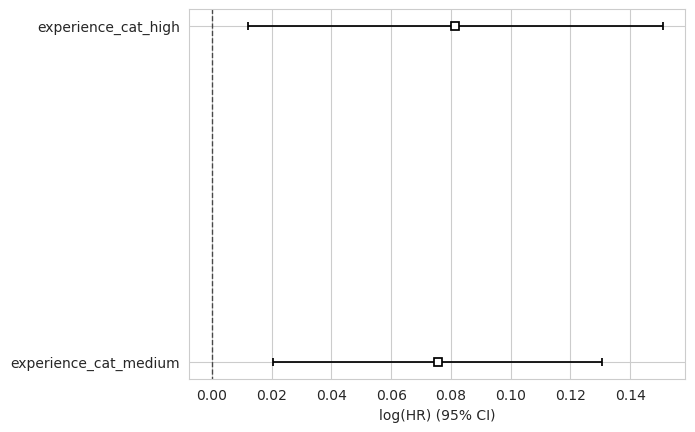

In [15]:
cph3 = lifelines.CoxPHFitter()
cph3.fit(df_ibs, duration_col='Survival_time', event_col='Event', formula = "experience_cat_high + experience_cat_medium")
cph3.print_summary()
cph3.plot()

In dit derde model hebben we enkel nog significante factoren zitten, dit zijn `experience_cat_high` en `experience_cat_medium` met een hazard ratio van `1.08` voor allebei. 

Dit betekent dat ten opzichte van `experience_cat_low` de instantane kans op het optreden van een event (ticket afronden) ongeveer $8\%$ hoger is voor zowel `experience_cat_medium` en `experience_cat_high` gegeven dat het event nog niet heeft plaatsgevonden.
